Part I: 
- runs all loading of the .dump files
- divides the loaded data into chunks: one chunk for each snapshot
- calculates the computationally heavy calculation of disp, N_N, d_5NN etc
- saves the dataframes with all required features into the features_csv folder

NB: All clustering algorithm calculation will be done in Part II


# Clustering Algorithm applied to atom classification

- Clustering algorithm used to classify atoms as crystal-like and glass-like based on the features
- Clustering applied to each snapshot
- Program must be run from the directory that contains individual directory for each snapshot
- Each directory must be named in a pre-defined fashion (0000ps, 0100ps, 0200ps,............., 2000ps)

In [1]:
import pyprind 
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

- *.dump file contains the dump obtained from the lammps output (Has all the LAMMPS calculated quantities for each atom)
- LAMMPS does not arrange the atoms in order of their indices like DL-POLY does

In [2]:
import glob, os

def load_dump_files(file_path, label):
    '''Inputs:
        file_path=path to the directories where the dump files are located
        label = ID for the atom in the LAMMPS dump file
       Outputs:
        dump_contents = contents of variable values form all the snapshots in chronological order
        num_snaps = total number of snapshots present in the study       
        box = list of the box size at each snapshot
    '''
    dump_contents, box = [],[]
    files = sorted(glob.glob(file_path, recursive=True))
    num_snaps = 0
    for filename in files:
        num_snaps += 1
        with open(filename, 'r',encoding='utf-8') as infile:
            print(filename)
            txt = infile.readlines()
            for line in txt[9:]:
                if line.split()[1] == label: # "1" = Li, "2"=Nb, "3"=O
                    dump_contents.append(np.array(line.split()).astype(float) )
            box.append(float(txt[5].split()[1]) - float(txt[5].split()[0]))
    return dump_contents, num_snaps, box


In [3]:
# label="3" for O, "2" for Nb, "1" for Li
dump_contents, num_snaps, box = load_dump_files(file_path = './*/**.dump', label="3")

./0000ps/0ps.dump
./0100ps/100ps.dump
./0200ps/200ps.dump
./0300ps/300ps.dump
./0400ps/400ps.dump
./0500ps/500ps.dump
./0600ps/600ps.dump
./0700ps/700ps.dump
./0800ps/800ps.dump
./0900ps/900ps.dump
./1000ps/1000ps.dump
./1100ps/1100ps.dump
./1200ps/1200ps.dump
./1300ps/1300ps.dump
./1400ps/1400ps.dump
./1500ps/1500ps.dump
./1600ps/1600ps.dump
./1700ps/1700ps.dump
./1800ps/1800ps.dump
./1900ps/1900ps.dump
./2000ps/2000ps.dump
./2100ps/2100ps.dump
./2200ps/2200ps.dump
./2300ps/2300ps.dump


In [4]:
print(box)

[106.1449154154, 113.1489732218, 113.108543005, 113.1765398784, 113.058117359, 113.0600140742, 112.965628167, 112.9430636634, 112.915350435, 112.8978251152, 112.871988558, 112.830578368, 112.7338670678, 112.7896574534, 112.6418809246, 112.6048737548, 112.537980012, 112.5292218986, 112.4503231704, 112.4459016328, 112.424878485, 112.4499270164, 112.37435433, 112.3646831744]


In [4]:
NAT=(int(len(dump_contents)/num_snaps))
print("No. of atoms: %d \nNo. of snaps: %d"%(NAT, num_snaps))


No. of atoms: 60720 
No. of snaps: 24


In [5]:
# Convert the dump_contents list into a dataframe and name the columns
df = pd.DataFrame(dump_contents)

df.columns=['ID',"Atom","x","y","z","Q4","Q6","Q8","Q10","Nc_6","Nc_8","c_x","c_y","c_z"]
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1457280 entries, 0 to 1457279
Data columns (total 14 columns):
 #   Column  Non-Null Count    Dtype  
---  ------  --------------    -----  
 0   ID      1457280 non-null  float64
 1   Atom    1457280 non-null  float64
 2   x       1457280 non-null  float64
 3   y       1457280 non-null  float64
 4   z       1457280 non-null  float64
 5   Q4      1457280 non-null  float64
 6   Q6      1457280 non-null  float64
 7   Q8      1457280 non-null  float64
 8   Q10     1457280 non-null  float64
 9   Nc_6    1457280 non-null  float64
 10  Nc_8    1457280 non-null  float64
 11  c_x     1457280 non-null  float64
 12  c_y     1396560 non-null  float64
 13  c_z     1396560 non-null  float64
dtypes: float64(14)
memory usage: 155.7 MB


In [6]:
# Change the data type of the columns appropriately
df = df.astype({"ID": int, "Atom": int, "Nc_6":int, "Nc_8":int})
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1457280 entries, 0 to 1457279
Data columns (total 14 columns):
 #   Column  Non-Null Count    Dtype  
---  ------  --------------    -----  
 0   ID      1457280 non-null  int64  
 1   Atom    1457280 non-null  int64  
 2   x       1457280 non-null  float64
 3   y       1457280 non-null  float64
 4   z       1457280 non-null  float64
 5   Q4      1457280 non-null  float64
 6   Q6      1457280 non-null  float64
 7   Q8      1457280 non-null  float64
 8   Q10     1457280 non-null  float64
 9   Nc_6    1457280 non-null  int64  
 10  Nc_8    1457280 non-null  int64  
 11  c_x     1457280 non-null  float64
 12  c_y     1396560 non-null  float64
 13  c_z     1396560 non-null  float64
dtypes: float64(10), int64(4)
memory usage: 155.7 MB


### Feature Engineering begins here

- Create a calculated column the find the distance from the center
- Remember the system has center at (0,0,0)
- Keep only columns that will be needed later

In [7]:
df['dist_from_c'] = np.sqrt((df['x']**2+df['y']**2+df['z']**2))
df = df[['ID','x','y','z','Q6','Nc_6','dist_from_c']]
df.describe()

,ID,x,y,z,Q6,Nc_6,dist_from_c
count,1.457280e+06,1.457280e+06,1.457280e+06,1.457280e+06,1.457280e+06,1.457280e+06,1.457280e+06
mean,6.934650e+04,2.149098e-02,-6.712331e-02,6.902881e-02,2.850517e-01,5.552400e+00,5.362045e+01
std,1.752836e+04,3.227645e+01,3.227144e+01,3.224347e+01,5.236759e-02,6.155435e+00,1.573885e+01
min,3.898700e+04,-5.658690e+01,-5.658580e+01,-5.658560e+01,6.792400e-02,0.000000e+00,7.020319e-01
25%,5.416675e+04,-2.772940e+01,-2.786270e+01,-2.763520e+01,2.487570e-01,1.000000e+00,4.338106e+01
50%,6.934650e+04,-8.050660e-03,-1.008390e-01,1.050005e-01,2.838500e-01,3.000000e+00,5.495657e+01
75%,8.452625e+04,2.780213e+01,2.771963e+01,2.781615e+01,3.203342e-01,8.000000e+00,6.488328e+01
max,9.970600e+04,5.658760e+01,5.658760e+01,5.658670e+01,4.962560e-01,3.500000e+01,9.730568e+01


__Looks exactly the way we want our data to be!__

- To perform clustering on each snapshot, we need to divide the dataframe into chunks for each snapshot
- Each chunk must have NAT atoms
- Each chunk needs to be sorted because the LAMMPS dump does not sort by ID

In [8]:
split_dataframes = [df[i:i+NAT] for i in range(0, len(df), NAT)]
sorted_chunks = [chunk.sort_values(by='ID') for chunk in split_dataframes]

# If you want to see what the chunks look like, uncomment the lines below
# for i, split_df in enumerate(sorted_chunks):
#     print(f"DataFrame {i + 1}:")
#     print(split_df)
#     print()

# Use the describe method to check the details of one of the chunks
# count row must have values equal to NAT
sorted_chunks[0].describe()


,ID,x,y,z,Q6,Nc_6,dist_from_c
count,60720.00000,60720.000000,60720.000000,60720.000000,60720.000000,60720.000000,60720.000000
mean,69346.50000,-0.046625,-0.008188,-0.002594,0.276680,3.725445,50.948510
std,17528.49851,30.635311,30.624634,30.623338,0.045565,4.845830,14.777960
min,38987.00000,-53.070800,-53.072300,-53.072000,0.067924,0.000000,1.421918
25%,54166.75000,-26.605975,-26.557825,-26.518375,0.246644,1.000000,41.422987
50%,69346.50000,-0.114935,-0.001707,0.246875,0.277063,2.000000,52.236671
75%,84526.25000,26.449075,26.515525,26.522725,0.307483,4.000000,61.532371
max,99706.00000,53.069300,53.072200,53.071300,0.459886,31.000000,90.774653


## One more feature (Displacement)


### __How do we calculate the displacement feature?__   
- For each snapshot, calculate the disp for each atom at four different 5ps snaps just before or after the snap
- For e.g, the disp for 200ps is calculated as the average of the disp at 195 ps, 190ps, 185ps, 180ps
- disp at 195: dist(r_195ps, r_190ps)
- We need to pull out the coordinates from the HISTORY file to do so

In [9]:
def periodic_distance(atom, nbd, box):
    '''Inputs:
        atom = coordinate of a single reference atom
        nbd = array of coordinates of multiple atoms
        box = length of the box
       Outputs:
        dis = distance between atom and nbd
        len(dis) == len(nbd)
    '''
    delta = np.abs(atom-nbd)
    delta = np.where(delta> 0.5*box, delta-box, delta)
    dis = np.sqrt((delta**2).sum(axis=-1))
    return dis

In [10]:
from tqdm import tqdm

search_string = "O2"
found = False

coords_A0=[]
with open("B0/HISTORY", "r") as file:
    total_lines = sum(1 for _ in file)
    file.seek(0)  # Reset the file pointer to the beginning
    progress_bar = tqdm(total=total_lines, desc="Processing")

    for line in file:
        progress_bar.update(1)  # Update the progress bar
        if search_string in line:
            found = True
        elif found:
            # Print or store the following line
            coords_A0.append(np.asarray(line.split()).astype(float))  # or do something else with the line
            found = False

    progress_bar.close()  # Close the prog

coords_A0 = np.asarray(coords_A0).astype(float)
print(np.shape(coords_A0))
print(f"Number of snaps in the HISTORY file is {int(len(coords_A0)/NAT)}")

Processing: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 55836482/55836482 [01:22<00:00, 676083.24it/s]


(17001600, 3)
Number of snaps in the HISTORY file is 280


- 100ps.lammps was taken from the 20st set of coordinates from the A0/HISTORY file. 
- choose the neighboring sets of coordianates to calculate the displacement. 
- 100ps - 20
- 200ps - 40
- 300ps - 60
- 800ps - 160

- if you want to pull out the 20set of coordinates you will need the slice coords_A0[19NAT:20NAT, :]

- use coords_A0 for calculating disp for 100ps, 200ps, ............., 800ps.
 
- skipping the calculation on 0ps ( start the loop at 1, i.e. chunks for 100ps)

- choose snaps_A0 wisely: Remember how many snaps were taken from A0/HISTORY? Our last snap from A0/HISTORY was 800ps. So our loop must run for 8 iterations (100ps, 200ps, ............, 800ps)

In [11]:
snaps_A0 = 14

for ind in range(1, snaps_A0+1):
    # Locate the starting index for the snapshot 100ps (if ind=1), 200ps(if ind=2),etc.
    # 20th set will have slice indices [19*NAT, 20*NAT]
    s1 = int((ind*100)/5.-1)*NAT
    
    snap_ = coords_A0[s1: s1+NAT, :]
    nbd_1 = coords_A0[s1-NAT: s1, :]
    nbd_2 = coords_A0[s1-2*NAT: s1-NAT, :]
    nbd_3 = coords_A0[s1-3*NAT: s1-2*NAT, :]
    nbd_4 = coords_A0[s1-4*NAT: s1-3*NAT, :]

    d1 = periodic_distance(snap_, nbd_1, box[ind])
    d2 = periodic_distance(nbd_1, nbd_2, box[ind])
    d3 = periodic_distance(nbd_2, nbd_3, box[ind])
    d4 = periodic_distance(nbd_3, nbd_4, box[ind])
    print(np.mean(d1), np.mean(d2), np.mean(d3), np.mean(d4))

    dist = 0.25*(d1+d2+d3+d4)
    sorted_chunks[ind]['disp'] = dist

1.937002060238202 1.9709889917977443 1.924912613990549 1.916915920231431
1.8962312060449067 1.8957632426312636 1.9169846328161948 1.9077383936573797
1.9067307956901756 1.8767388381277519 1.8949645734619514 1.9184201877261695
1.8445604517979555 1.84532278079886 1.87109132589962 1.890048472320076
1.8433978684537324 1.841954576321654 1.8757919598568862 1.8600627186381002
1.815188529138395 1.8161184974939442 1.8012938806829368 1.8286453336808548
1.7769453664181938 1.7931396956015946 1.7635914203799707 1.7893907456397753
1.7377929768233578 1.7531795908649488 1.7319789031810284 1.767655564177261
1.7056515343385341 1.7329930094514092 1.7022606612711453 1.6901680167174733
1.6866281168952129 1.680037785894555 1.638962618831344 1.665487795724826
1.6526217602935473 1.6519480309092212 1.6054025730416086 1.6258334658968918
1.6104906719142345 1.6129007426957473 1.5900281843831612 1.606929237310591
1.5489045299322781 1.5368174564440675 1.5425575768419149 1.5584881642078092
1.498452297789089 1.5166886

In [12]:
sorted_chunks[14].describe()

,ID,x,y,z,Q6,Nc_6,dist_from_c,disp
count,60720.00000,60720.000000,60720.000000,60720.000000,60720.000000,60720.000000,60720.000000,60720.000000
mean,69346.50000,0.017279,-0.122224,0.163733,0.286404,5.770833,53.616324,1.508020
std,17528.49851,32.260745,32.290786,32.242962,0.052766,6.218291,15.758922,0.890790
min,38987.00000,-56.320500,-56.320300,-56.319500,0.096001,0.000000,1.928322,0.173906
25%,54166.75000,-27.671800,-27.846925,-27.526075,0.249582,1.000000,43.311645,0.701196
50%,69346.50000,-0.028276,-0.153907,0.182716,0.285310,3.000000,54.910079,1.377861
75%,84526.25000,27.769525,27.625100,28.013575,0.322398,9.000000,64.961179,2.137482
max,99706.00000,56.317500,56.317800,56.319700,0.471156,34.000000,96.417260,6.323661


__Great! We now have two new features added to our data__
- Let us do the same for the A1/HISTORY

In [13]:
found = False

coords_A1=[]
with open("B1/HISTORY", "r") as file:
    total_lines = sum(1 for _ in file)
    file.seek(0)  # Reset the file pointer to the beginning
    progress_bar = tqdm(total=total_lines, desc="Processing")
    for line in file:
        progress_bar.update(1)  # Update the progress bar
        if search_string in line:
            found = True
        elif found:
            coords_A1.append(np.asarray(line.split()).astype(float))  # or do something else with the line
            found = False
    progress_bar.close()  

coords_A1 = np.asarray(coords_A1).astype(float)
print(np.shape(coords_A1))
print(f"Number of snaps in the HISTORY file is {int(len(coords_A1)/NAT)}.")

Processing: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 39524237/39524237 [00:58<00:00, 678759.66it/s]


(12032520, 3)
Number of snaps in the HISTORY file is 198.


- 1500ps.lammps was taken from the 20th set of coordinates from the A1/HISTORY file. 


Let us use coords_A1 for calculating disp for 1500ps, 1600ps, ............., 2300ps.

In [14]:
for ind in range(1,num_snaps-snaps_A0):
    
    s1 = int((ind*100)/5.-1)*NAT

    snap_ = coords_A1[s1: s1+NAT, :]
    nbd_1 = coords_A1[s1-NAT: s1, :]
    nbd_2 = coords_A1[s1-2*NAT: s1-NAT, :]
    nbd_3 = coords_A1[s1-3*NAT: s1-2*NAT, :]
    nbd_4 = coords_A1[s1-4*NAT: s1-3*NAT, :]
    
    d1 = periodic_distance(snap_, nbd_1, box[ind])
    d2 = periodic_distance(nbd_1, nbd_2, box[ind])
    d3 = periodic_distance(nbd_2, nbd_3, box[ind])
    d4 = periodic_distance(nbd_3, nbd_4, box[ind])
    print(np.mean(d1), np.mean(d2), np.mean(d3), np.mean(d4))


    dist = 0.25*(d1+d2+d3+d4)
    sorted_chunks[ind+snaps_A0]['disp'] = dist

1.4410200799525357 1.4633817106821019 1.4560815711522428 1.4644249863786865
1.3908679477859078 1.400614716541772 1.4245152376961967 1.4090734863134584
1.3535336642332938 1.3553561065448607 1.357704402460268 1.3497114677181645
1.2842297741353905 1.3010224671687924 1.3219345057771694 1.327098851850332
1.2501092690544495 1.254982545371386 1.263928892657684 1.2828852077997066
1.218284135883349 1.2301129015635754 1.2207201072832834 1.2339970562227052
1.1714353733208092 1.1702212163844468 1.1772382487531872 1.1545707184422906
1.1387400686549258 1.1404784725430785 1.129785521249375 1.116468413799107
1.0618605701641581 1.0854512325826617 1.0755659671255395 1.0669313084167713


In [15]:
# sorted_chunks[12].describe()
sorted_chunks[23].describe()

,ID,x,y,z,Q6,Nc_6,dist_from_c,disp
count,60720.00000,60720.000000,60720.000000,60720.000000,60720.000000,60720.000000,60720.000000,60720.000000
mean,69346.50000,0.056318,-0.217646,0.198683,0.300641,9.849292,53.227582,1.072452
std,17528.49851,32.063728,31.979916,31.967151,0.054807,7.042071,15.477865,0.939838
min,38987.00000,-56.176600,-56.181800,-56.180400,0.098908,0.000000,1.915064,0.166063
25%,54166.75000,-27.338150,-27.665525,-27.112600,0.262521,3.000000,43.249795,0.547561
50%,69346.50000,0.015816,-0.288767,0.252420,0.300952,9.000000,54.532181,0.688646
75%,84526.25000,27.545150,27.165275,27.515625,0.340085,15.000000,64.145024,1.001961
max,99706.00000,56.179800,56.177700,56.181600,0.480463,32.000000,95.880248,7.604327


- Great the disp features has been added to 100ps, 200ps, .............., 1700ps
## More features (d_5NN, N_N)


### __How do we calculate these features?__   
- __d_5NN__: average distance of 5 nearest neighbors with Nc > 10 
- __N_N__: number of atoms with 5A that have Nc > 10

In [16]:
for ind in range(1,num_snaps):
    '''num_neigh_list = list of number of neighbors within 5A with Nc > 10
       avg_neigh_dist = average distance of 5 nearest neighbors with Nc > 10
    '''
    num_neigh_list, avg_neigh_dist = [], []
    df_snap=sorted_chunks[ind]
    print(f"Working on {ind*100} ps.")
    prog_bar = pyprind.ProgBar(len(df_snap))
    for j in range(len(df_snap)):
        filtered_particles = df_snap[df_snap['Nc_6'] > 10]
        particle_row = df_snap.iloc[j]
        coordinates = [particle_row['x'], particle_row['y'], particle_row['z']]
        distances = periodic_distance(coordinates, filtered_particles[['x','y','z']], box[ind])
        sorted_distances = np.sort(distances)
        # List of 5 nearest neighbors with Nc > 10
        # If the reference atom itself has Nc > 10, the min value of distance will be 0 and that must be removed
        nbd_5 = np.mean(sorted_distances[1:6]) if sorted_distances[0] == 0\
                else np.mean(sorted_distances[:5])
        avg_neigh_dist.append(nbd_5)
        
        num_neigh = (len([x for x in distances if x < 5.0]) -1) if min(distances) == 0\
                    else len([x for x in distances if x < 5.0])    
        num_neigh_list.append(num_neigh)
        prog_bar.update()
# Add the list as a column to the dataframe chunk
    sorted_chunks[ind]['d_5NN'] = avg_neigh_dist
    sorted_chunks[ind]['N_N'] = num_neigh_list


Working on 100 ps.


0% [##############################] 100% | ETA: 00:00:00

Working on 200 ps.



Total time elapsed: 00:01:35
0% [##############################] 100% | ETA: 00:00:00

Working on 300 ps.



Total time elapsed: 00:01:44
0% [##############################] 100% | ETA: 00:00:00

Working on 400 ps.



Total time elapsed: 00:01:55
0% [##############################] 100% | ETA: 00:00:00

Working on 500 ps.



Total time elapsed: 00:02:22
0% [##############################] 100% | ETA: 00:00:00

Working on 600 ps.



Total time elapsed: 00:02:44
0% [##############################] 100% | ETA: 00:00:00

Working on 700 ps.



Total time elapsed: 00:02:28
0% [##############################] 100% | ETA: 00:00:00

Working on 800 ps.



Total time elapsed: 00:02:37
0% [##############################] 100% | ETA: 00:00:00

Working on 900 ps.



Total time elapsed: 00:02:51
0% [##############################] 100% | ETA: 00:00:00

Working on 1000 ps.



Total time elapsed: 00:03:04
0% [##############################] 100% | ETA: 00:00:00

Working on 1100 ps.



Total time elapsed: 00:03:18
0% [##############################] 100% | ETA: 00:00:00

Working on 1200 ps.



Total time elapsed: 00:03:37
0% [##############################] 100% | ETA: 00:00:00

Working on 1300 ps.



Total time elapsed: 00:03:48
0% [##############################] 100% | ETA: 00:00:00

Working on 1400 ps.



Total time elapsed: 00:04:03
0% [##############################] 100% | ETA: 00:00:00

Working on 1500 ps.



Total time elapsed: 00:04:19
0% [##############################] 100% | ETA: 00:00:00

Working on 1600 ps.



Total time elapsed: 00:04:40
0% [##############################] 100% | ETA: 00:00:00

Working on 1700 ps.



Total time elapsed: 00:05:07
0% [##############################] 100% | ETA: 00:00:00

Working on 1800 ps.



Total time elapsed: 00:05:32
0% [##############################] 100% | ETA: 00:00:00

Working on 1900 ps.



Total time elapsed: 00:05:45
0% [##############################] 100% | ETA: 00:00:00

Working on 2000 ps.



Total time elapsed: 00:06:13
0% [##############################] 100% | ETA: 00:00:00

Working on 2100 ps.



Total time elapsed: 00:06:24
0% [##############################] 100% | ETA: 00:00:00

Working on 2200 ps.



Total time elapsed: 00:07:04
0% [##############################] 100% | ETA: 00:00:00

Working on 2300 ps.



Total time elapsed: 00:07:20
0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:07:44


In [17]:
import pandas as pd
import os

# Create a directory to store CSV files
output_directory = "features_csv"
os.makedirs(output_directory, exist_ok=True)

# Loop through the DataFrames and save them as CSV files
for ind in range(1, num_snaps):
    # Define the file name (you can customize this)
    file_name = os.path.join(output_directory, f"{ind*100}.csv")
    
    # Save the DataFrame as a CSV file
    sorted_chunks[ind].to_csv(file_name, index=False)

print("CSV files saved successfully.")


CSV files saved successfully.


__Let us look at how our variables are correlated__


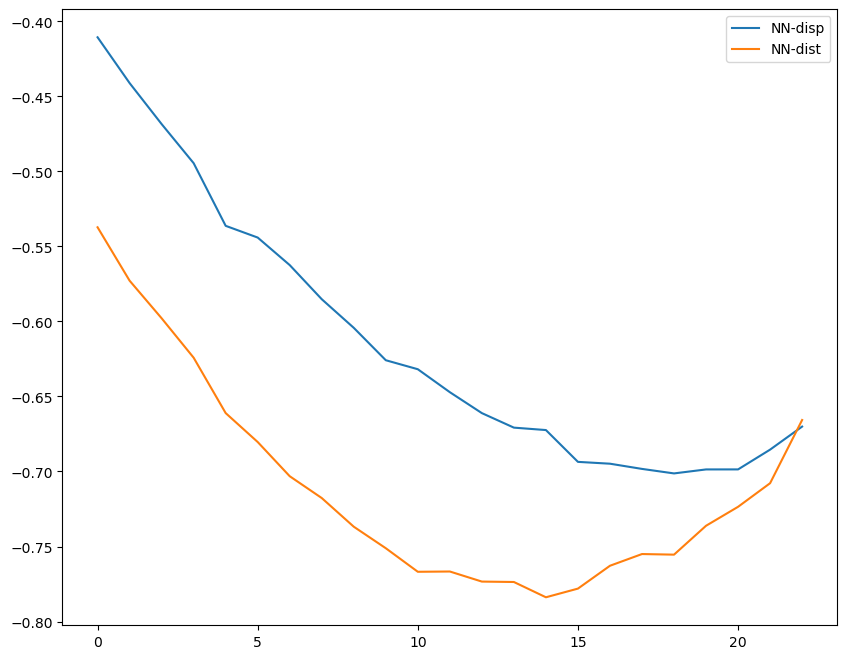

In [35]:
import seaborn as sns
import matplotlib.pyplot as plt

NN_disp_corr, NN_Nc_corr, NN_dist_corr = [],[],[]
for ind in range(1,num_snaps):
    data = sorted_chunks[ind][['Q6','Nc_6','disp','N_N','dist_from_c']]
    correlation_matrix = data.corr()
    NN_dist_corr.append(correlation_matrix['N_N'][4])
    NN_disp_corr.append(correlation_matrix['N_N'][2])
    NN_Nc_corr.append(correlation_matrix['N_N'][1])
# Create a heatmap of the correlation matrix
plt.figure(figsize=(10, 8))
plt.plot(NN_disp_corr, label="NN-disp")
plt.plot(NN_dist_corr, label="NN-dist")
# plt.plot(NN_Nc_corr, label="NN-Nc")
plt.legend()
# plt.savefig("conf_mat.png",dpi=500,bbox_inches='tight')
plt.show()


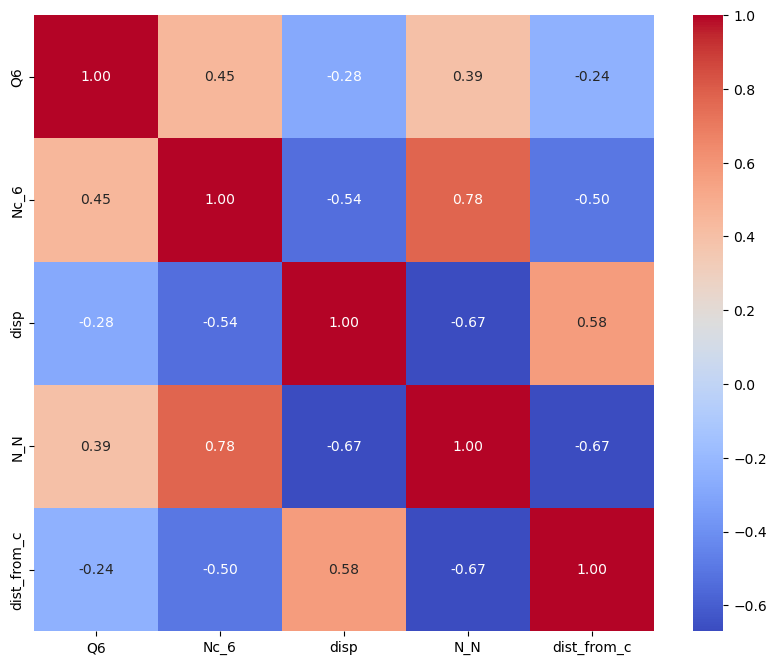

In [36]:
# Create a heatmap of the correlation matrix in the last snapshot
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.savefig("conf_mat.png",dpi=500,bbox_inches='tight')
plt.show()


__Save the cluster size evolution in to a file__

In [66]:
np.savetxt("c_size_evol.txt", n_atoms_per_cluster, delimiter='\t', fmt='%d')


__Save the dataframes with all features so that you need not do the calculation again__


In [71]:
import pandas as pd
import os

# Create a directory to store CSV files
output_directory = "csv_files"
os.makedirs(output_directory, exist_ok=True)

# Loop through the DataFrames and save them as CSV files
for ind in range(1, num_snaps):
    # Define the file name (you can customize this)
    file_name = os.path.join(output_directory, f"{ind*100}.csv")
    
    # Save the DataFrame as a CSV file
    sorted_chunks[ind].to_csv(file_name, index=False)

print("CSV files saved successfully.")


CSV files saved successfully.
